In [1]:
import pandas as pd
import re
import math
import time
import random
import matplotlib.pyplot as plt
import numpy as np

from deap import algorithms, base, creator, tools

In [2]:
# TSPLIB file reader
def read_tsplib_file(filename):
    if filename is None:
        raise FileNotFoundError('Filename can not be None')
    with open(filename) as file:
        lines = file.readlines()
        data = [line.lstrip() for line in lines if line != ""]
        dimension = re.compile(r'[^\d]+')
        for item in data:
            if item.startswith('DIMENSION'):
                dimension = int(dimension.sub('', item))
                break
        c = [-1.0] * (2 * dimension)
        cities_coord = []
        for item in data:
            if item[0].isdigit():
                j, coordX, coordY = [float(x.strip()) for x in item.split(' ')]
                c[2 * (int(j) - 1)] = coordX
                c[2 * (int(j) - 1) + 1] = coordY
                cities_coord.append([coordX, coordY])
        cities = pd.DataFrame(cities_coord)
        #         cities = cities_coord
        matrix = [[-1] * dimension for _ in range(dimension)]
        for k in range(dimension):
            matrix[k][k] = 0
            for j in range(k + 1, dimension):
                dist = math.sqrt((c[k * 2] - c[j * 2]) ** 2 + (c[k * 2 + 1] - c[j * 2 + 1]) ** 2)
                dist = round(dist)
                matrix[k][j] = dist
                matrix[j][k] = dist
        return matrix, dimension, cities

In [3]:
def evalTSP(individual):
    distance = dist_matrix[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_matrix[gene1][gene2]
    return distance,

In [4]:
def create_toolbox(num_cities, ind_mutpb, tourn_size):
    tb = base.Toolbox()

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", np.ndarray, typecode='i', fitness=creator.FitnessMin)
    
    tb.register("indices", np.random.permutation, num_cities)
    tb.register("individual", tools.initIterate, creator.Individual, tb.indices)
    tb.register("population", tools.initRepeat, list, tb.individual)

    tb.register("mate", tools.cxOrdered)
    tb.register("mutate", tools.mutShuffleIndexes, indpb=ind_mutpb) 
    tb.register("select", tools.selTournament, tournsize=tourn_size) 
    tb.register("evaluate", evalTSP)
    return tb

In [5]:
def create_stats():
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('min', np.min)
    return stats

In [6]:
# function to make print report of function solving

def print_solution(res, log, duration):
    
    solution_x = tools.selBest(res, k=1)[0]
    fitness = evalTSP(solution_x)[0]
    n_evals = sum([x['nevals'] for x in log])
    nb_gen = len(log)-1
    print('-' *60)
    print("Function: %s" % problem_name)
    print("Problem dimension: %d" % nb_cities)
    print("Global Optimum: %d" % optimal_fitness)
    print('-' *60)
    print("Algorithm: %s" % algorithm_name)
    print("Parameters:")
    for p in params:
        print("\t%s: " % p ,params[p] )
    print('-' *60)
    print("Fitness: %d" % fitness)
    print("Solution: ")
    print(solution_x)
    print('-' *60)
    print("Nb of functions evaluations: %d" % n_evals)
    print("Stopping criterion: after %d generations" % nb_gen)
    print("computational time: %.3f seconds" % duration)

    plt.plot(log.select('min'), 'c-')
    plt.ylabel('Fitness');
    plt.xlabel('Generations');
    plt.show()

In [7]:
# define algorithm parameters

algorithm_name = "Simple Evolutionary Algorithm"

pop_size = 200
nb_generations = 1000
cross_prob = 0.8

mut_prob = 0.1
indep_mut_prob = 0.02

tournament_size = 3

params = {"Population Size": pop_size, 
          "Nb of generations":nb_generations,
          "Crossover probability":cross_prob, 
          "Mutation Probability":mut_prob, 
          "Indep. gene mut prob": indep_mut_prob,
          "Tournament size": tournament_size
         }


In [8]:
# instantiate problem to solve

problem_name = 'Djibouti 38 TSP'
optimal_fitness = 6656
dist_matrix, nb_cities, cities_coord = read_tsplib_file('./dj38.tsp')

toolbox = create_toolbox(nb_cities, indep_mut_prob, tournament_size)
fit_stats = create_stats()

------------------------------------------------------------
Function: Djibouti 38 TSP
Problem dimension: 38
Global Optimum: 6656
------------------------------------------------------------
Algorithm: Simple Evolutionary Algorithm
Parameters:
	Population Size:  200
	Nb of generations:  1000
	Crossover probability:  0.8
	Mutation Probability:  0.1
	Indep. gene mut prob:  0.02
	Tournament size:  3
------------------------------------------------------------
Fitness: 7727
Solution: 
[36 37 32 33 35 30 26 27 18 17 15  7  6  5  4  2  3  1  0  9 13 20 28 22
 19 14 12  8 11 10 16 23 21 24 25 29 31 34]
------------------------------------------------------------
Nb of functions evaluations: 163799
Stopping criterion: after 1000 generations
computational time: 7.969 seconds


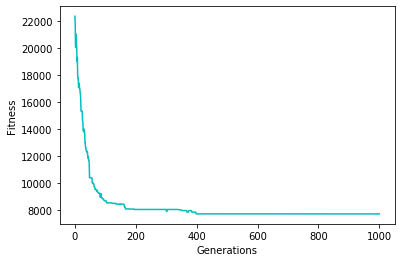

In [9]:
# run algorithm and print solution

random.seed(169)

t1 = time.time()
result, log = algorithms.eaSimple(toolbox.population(n=pop_size), 
                                  toolbox, 
                                  cxpb=cross_prob, 
                                  mutpb=mut_prob, 
                                  ngen=nb_generations, 
                                  verbose=False, 
                                  stats=fit_stats)
t2 = time.time()
print_solution(res=result, log=log, duration=t2-t1)

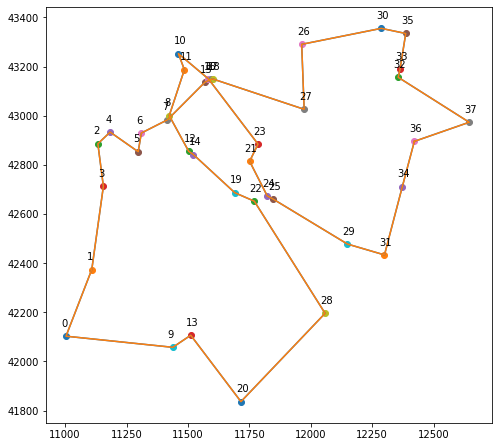

In [10]:
# display found solution

best_individual = tools.selBest(result, k=1)[0]

xlist = [cities_coord.iloc[i,0] for i in best_individual]
ylist = [cities_coord.iloc[i,1] for i in best_individual]

xlist.append(xlist[0])
ylist.append(ylist[0])

plt.figure(figsize=(8,8))
for idx,city in enumerate(cities_coord.values):
    plt.scatter(city[0],city[1])
    plt.text(city[0]-20, city[1]+40, str(idx), fontsize=10)

plt.plot(xlist, ylist, linestyle='-')
plt.plot(xlist, ylist, linestyle='-')
plt.axis('scaled')
plt.show()